Домашнее задание №3

Автор: Конанов Кирилл М05-012б

Расположение подписей

В решении использован библиотечный SAT-solver, и соответсвенно нет ограничений на количество вариантов размещения подписи

In [ ]:
! git clone https://github.com/kakonanov/MIPT_MathMethodsDataVis2021.git

Cloning into 'MIPT_MathMethodsDataVis2021'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 34 (delta 4), reused 24 (delta 2), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
!pip install python-constraint

  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24079 sha256=7f93437b7f8bd7859bf277b3d144e3d6529a3799d9608de544364dfd7b435f35
  Stored in directory: /root/.cache/pip/wheels/34/31/15/7b070b25d0a549d20ce2e9fe6d727471c2c61ef904720fd40c
Successfully built python-constraint


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import sys
import itertools
from shapely.geometry import Polygon
from constraint import *


Класс Box

Created by Игорь Дьяченко

Выражаю благодарность за предоставленние этого класса и данные!

In [ ]:
def parse(line):
  arr = [int(a) for a in line.split(',')]
  return (arr[0], arr[1])

class Box:
    def __init__(self, line):
      arr = line.split('\t')
      self.name = ""
      self.pos = parse(arr[0])
      self.size = parse(arr[1])
      self.offsets = [parse(offset) for offset in arr[2].split(' ')]
    
    def __str__(self):
      return 'Box(pos={}, size={}, offsets={})'.format(self.pos, self.size, self.offsets)
    
    def __repr__(self):
      return str(self)

In [ ]:
file = open('/content/MIPT_MathMethodsDataVis2021/task3/hard2.txt').read()
boxes = [Box(line) for line in file.strip().split('\n')]

In [ ]:
box_by_name = dict()
for i, box in  enumerate(boxes):
  box.name = 'b' + str(i)
  box_by_name[box.name] = box

In [ ]:
def ordered(arr):
  res = [arr[0]]
  s = set((1,2,3))
  prev = arr[0]
  for j in range(3):
    for i in s:
      elem = arr[i]
      if (prev[0] in elem or prev[1] in elem):
        prev = elem
        res += [elem]
        s.remove(i)
        break;
  return res

def get_coordinates(pos, size, offset):
  arr = np.array([pos]*4)
  offset_ =  np.array([offset]*4)
  bounds = np.array([(0, 0), (size[0], 0), (0, size[1]), (size[0], size[1])])
  res = arr + bounds - offset_
  return ordered(res)


def is_intersects(first, second):
  p = Polygon(first)
  q = Polygon(second)
  return p.intersects(q)


In [ ]:
class BoxesInter:
    def __init__(self, box_one, box_two):
      self.box_one = box_one
      self.box_two = box_two
      self.s = []
      self.indexes = []
    
    def __str__(self):
      return 'BoxesInter(box_one={}, box_two={}, s={}, indexes={})'.format(self.box_one, self.box_two, self.s, self.indexes)

    def add_offsets_indexes(self, offset_index_first, offset_index_second):
      self.indexes += [((offset_index_first, offset_index_second))]

    def __repr__(self):
      return str(self)

In [ ]:
def get_mapa(boxes):
  mapa = dict()

  for (box_one, box_two) in itertools.combinations(boxes, 2):
    for ind_first, offset_first in enumerate(box_one.offsets):
      for ind_second, offset_second in enumerate(box_two.offsets):
        if is_intersects(
            get_coordinates(box_one.pos, box_one.size, offset_first),
            get_coordinates(box_two.pos, box_two.size, offset_second)
        ):
          if (box_one.pos, box_two.pos) not in mapa:
            mapa[box_one.pos, box_two.pos] = BoxesInter(box_one, box_two)
          mapa[box_one.pos, box_two.pos].add_offsets_indexes(ind_first, ind_second)
  return mapa

def get_lambda(indexes):
  return lambda a, b: (a, b) not in indexes

In [ ]:
problem = Problem()
for box in boxes:
  problem.addVariable(box.name, range(len(box.offsets)))

mapa = get_mapa(boxes)
for v in mapa.values():
  x1 = v.box_one.name
  x2 = v.box_two.name
  problem.addConstraint(get_lambda(v.indexes), [x1, x2])

In [ ]:
def draw_solution(solution, boxes):
  figure, ax = plt.subplots()
  figure.set_figheight(12)
  figure.set_figwidth(12)
  for box in boxes:
    point = (box.pos[0] - box.offsets[solution[box.name]][0],
             box.pos[1] - box.offsets[solution[box.name]][1])
    ax.scatter(box.pos[0], box.pos[1], s=20, c = 'b')
    ax.add_patch(Rectangle(point, box.size[0], box.size[1], edgecolor='black', facecolor='none'))
  plt.show()

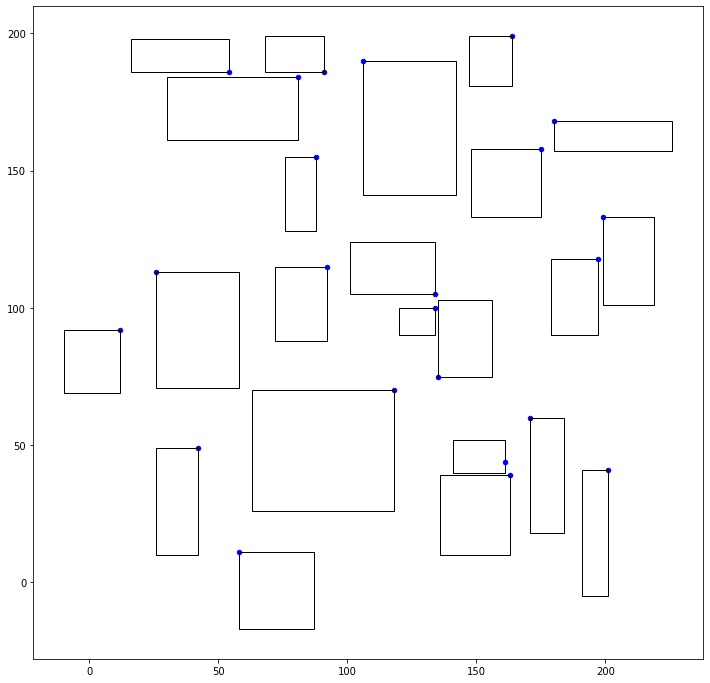

In [ ]:
solution = problem.getSolution()
draw_solution(solution, boxes)